In [ ]:
!pip install ultralytics

In [2]:
from ultralytics import YOLO
model = YOLO('/content/yolo11m-pose.pt')

results1 = model.track('/content/sprint loop.mp4', save=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.8s, installed 1 package: ['lap>=0.5.12']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.b

In [4]:
import cv2

def get_frame_count(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Release the video capture object
    cap.release()

    return frame_count, fps

# Example usage
video_path = '/content/sprint loop.mp4'
total_frames, fps = get_frame_count(video_path)
print(f"Total number of frames: {total_frames}")
print(f"fps: {fps}")
print(f"length of the results obj: {len(results1)}")


Total number of frames: 737
fps: 29.97002997002997
length of the results obj: 737


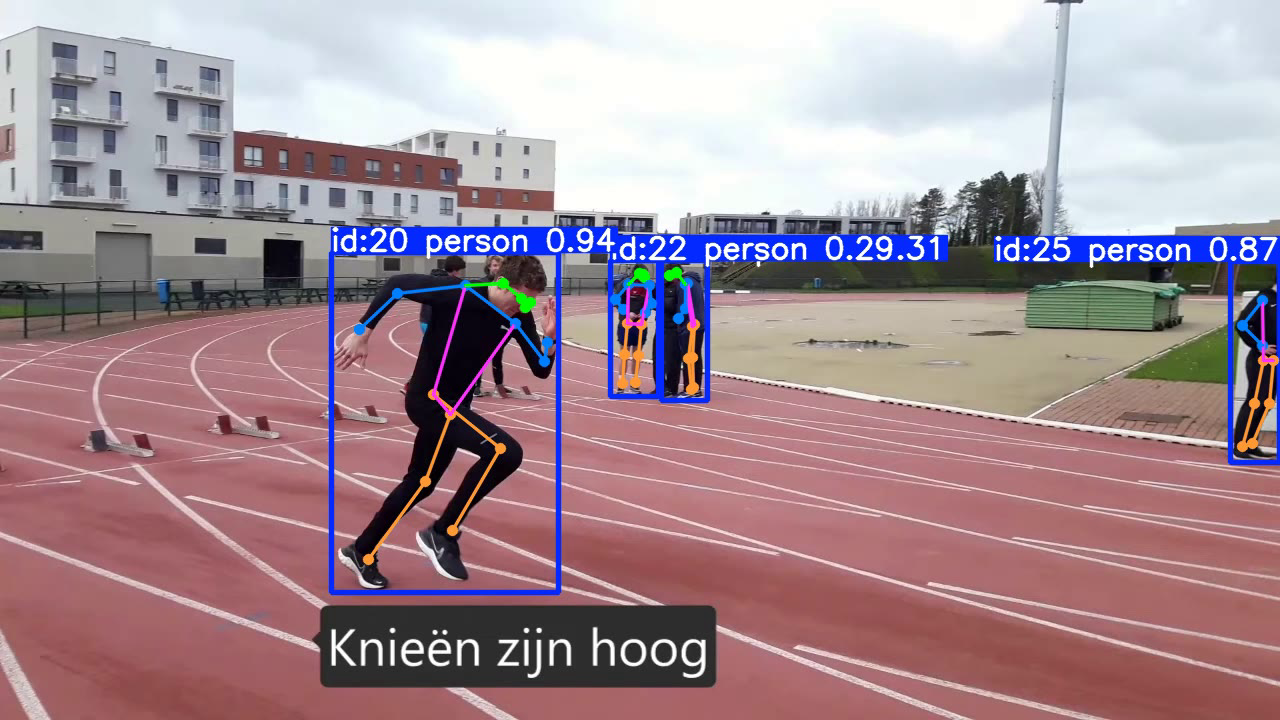

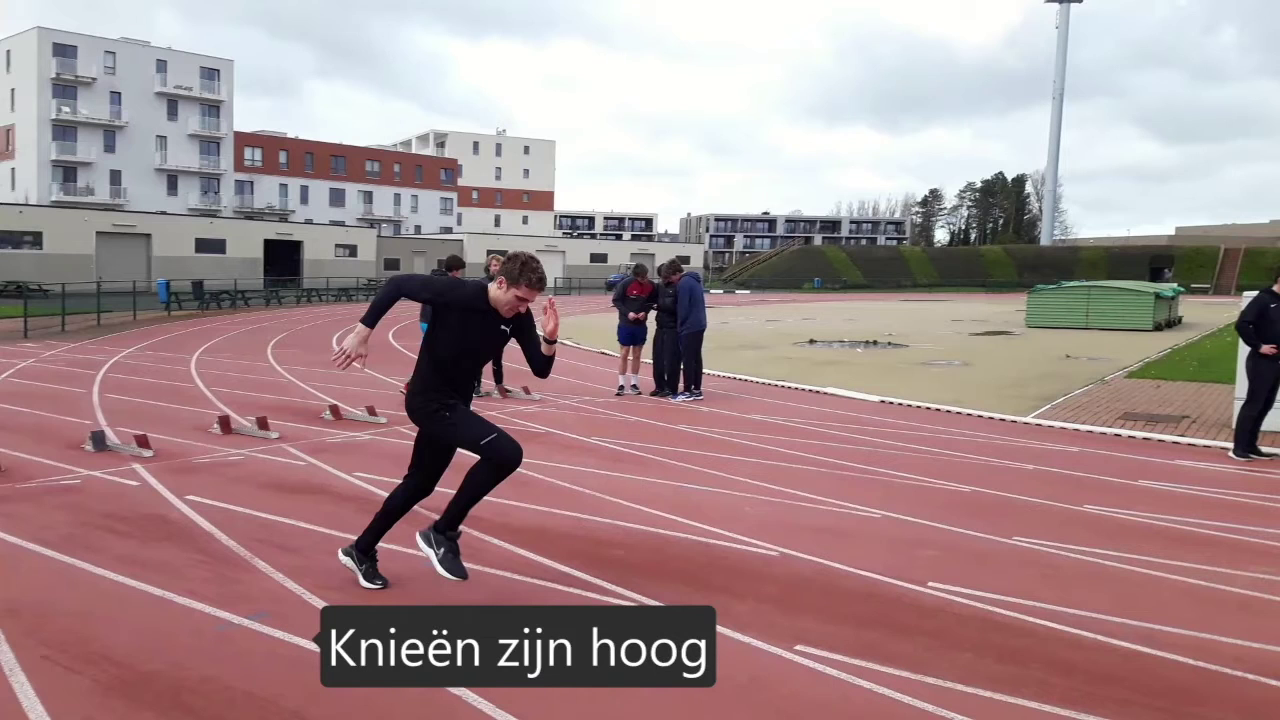

In [6]:
import cv2
import math
from google.colab.patches import cv2_imshow

def get_frame_from_timestamp(video_path, timestamp, fps):
    # Calculate the frame number from the timestamp
    frame_number = math.floor(timestamp * fps)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Set the video position to the frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()
    cap.release()

    if ret:
        return frame, frame_number
    else:
        print("Frame could not be retrieved.")
        return None

# Example usage
video_path = '/content/runs/pose/track/sprint loop.avi'
timestamp = 10.0  # seconds
fps = 29.97  # from your previous output

frame, num = get_frame_from_timestamp(video_path, timestamp, fps)

# Display the frame using OpenCV (Optional)
if frame is not None:
    cv2_imshow( frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

cv2_imshow(results1[num].orig_img)


In [8]:
import ultralytics

def get_player_coords(player_id: int, results: list[ultralytics.engine.results.Results]):
    player_coords = []

    # Iterate through each result with an associated frame index
    for frame_index, result in enumerate(results):
        if hasattr(result, 'boxes') and hasattr(result, 'keypoints'):
            boxes = result.boxes
            keypoints = result.keypoints

            if boxes is not None and keypoints is not None:
                tracking_ids = boxes.id
                kp_xyn = keypoints.xyn  # normalized xy coords

                if tracking_ids is not None:
                    for track_id, kp in zip(tracking_ids, kp_xyn):
                        if int(track_id) == player_id:
                            # Append keypoints along with the frame number
                            player_coords.append({'frame': frame_index, 'keypoints': kp})
    return player_coords



In [9]:
player_coords = get_player_coords(2, results1)
player_coords[:1]

[{'frame': 0,
  'keypoints': tensor([[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.4651, 0.5304],
          [0.4788, 0.5249],
          [0.4525, 0.5231],
          [0.4802, 0.5649],
          [0.4432, 0.5603],
          [0.4845, 0.5989],
          [0.4388, 0.5971],
          [0.4550, 0.4813],
          [0.4368, 0.4797],
          [0.4595, 0.5476],
          [0.4381, 0.5470],
          [0.4495, 0.5915],
          [0.4241, 0.5917]], device='cuda:0')}]

0: Nose 1: Left Eye 2: Right Eye 3: Left Ear 4: Right Ear
5: Left Shoulder 6: Right Shoulder
7: Left Elbow 8: Right Elbow
9: Left Wrist 10: Right Wrist
11: Left Hip 12: Right Hip
13: Left Knee 14: Right Knee 15:
Left Ankle 16: Right Ankle

In [10]:
import numpy as np

# Function to calculate angles between three points
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)
    return angle if angle <= 180 else 360 - angle

# Function to retrieve a keypoint
def get_keypoint(keypoints, keypoint_index):
    try:
        return keypoints[keypoint_index].tolist()
    except (IndexError, AttributeError):
        return None

# Function to calculate the midpoint between two points
def get_midpoint(point1, point2):
    return [(point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2]


In [12]:
def sprint_start_crit_3(knee_angles, threshold=160, required_change=20):
    """
    Track changes in knee angles over time to determine if a powerful push-off has occurred.
    """
    if len(knee_angles) < 2:
        return False

    # Calculate the change in angles
    angle_changes = [j - i for i, j in zip(knee_angles[:-1], knee_angles[1:])]

    # Check if the last angle is above the threshold and the change is sufficient
    if knee_angles[-1] > threshold and max(angle_changes) > required_change:
        return True

    return False

def sprint_start_crit_5(left_knee_angles, right_knee_angles, extended_threshold=150, contracted_threshold=100):
    """
    Check if one leg is almost fully extended while the other is contracted.
    """
    if len(left_knee_angles) < 1 or len(right_knee_angles) < 1:
        return False

    # Check the last angles for both legs
    left_extended = left_knee_angles[-1] > extended_threshold
    right_contracted = right_knee_angles[-1] < contracted_threshold

    left_contracted = left_knee_angles[-1] < contracted_threshold
    right_extended = right_knee_angles[-1] > extended_threshold

    # Check if one leg is extended and the other is contracted
    if (left_extended and right_contracted) or (left_contracted and right_extended):
        return True

    return False


def evaluate_sprint_start(player_coords):
    scoring = {'pelvis_higher_than_shoulders': 0, 'head_aligned_with_torso': 0,
               'legs_push_off_powerfully': 0, 'gaze_directed_downwards': 0,
               'back_leg_full_extension': 0}

    # Initialize lists to track knee angles over time
    left_knee_angles = []
    right_knee_angles = []

    evaluation_frames = {1:[],2:[],3:[],4:[],5:[]}

    for data in player_coords:
        frame = data['frame']
        keypoints = data['keypoints']
        left_hip = get_keypoint(keypoints, 11)
        right_hip = get_keypoint(keypoints, 12)
        left_shoulder = get_keypoint(keypoints, 5)
        right_shoulder = get_keypoint(keypoints, 6)
        left_ear= get_keypoint(keypoints, 3)
        right_ear = get_keypoint(keypoints, 4)
        nose = get_keypoint(keypoints, 0)
        left_knee = get_keypoint(keypoints, 13)
        left_ankle = get_keypoint(keypoints, 15)
        right_knee = get_keypoint(keypoints, 14)
        right_ankle = get_keypoint(keypoints, 16)

        if not (left_hip and right_hip and left_shoulder and left_knee and left_ankle and right_knee and right_ankle):
            continue

        mid_hip = get_midpoint(left_hip, right_hip)
        mid_ear = get_midpoint(left_ear, right_ear)
        mid_shoulder = get_midpoint(left_shoulder, right_shoulder)

        # Criterion 1: pelvis slightly higher than the shoulders
        if mid_hip[1] < mid_shoulder[1]:
            scoring['pelvis_higher_than_shoulders'] = 1
            evaluation_frames[1].append(frame)

        # Criterion 2: Head aligned with torso
        body_tilt_angle = calculate_angle(mid_hip, mid_ear, mid_shoulder)
        if 0 <= body_tilt_angle <= 4:
            scoring['head_aligned_with_torso'] = 1
            evaluation_frames[2].append(frame)


        # Track knee angles over time
        left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)

        left_knee_angles.append(left_knee_angle)
        right_knee_angles.append(right_knee_angle)


        # Check if legs push off powerfully
        if sprint_start_crit_3(left_knee_angles) and sprint_start_crit_3(right_knee_angles):
            scoring['legs_push_off_powerfully'] = 1
            evaluation_frames[3].append(frame)

        # Criterion 4: One leg extended, the other contracted i.e. full extension of the back leg
        if sprint_start_crit_5(left_knee_angles, right_knee_angles):
            scoring['back_leg_full_extension'] = 1
            evaluation_frames[5].append(frame)


    return scoring, evaluation_frames


In [13]:
scoring, eval = evaluate_sprint_start(player_coords)
print(f'scoring: {scoring}\nevaluations num:')
for i in eval.values():
  print(len(i))

scoring: {'pelvis_higher_than_shoulders': 1, 'head_aligned_with_torso': 1, 'legs_push_off_powerfully': 1, 'gaze_directed_downwards': 0, 'back_leg_full_extension': 1}
evaluations num:
13
20
48
0
1


In [62]:

def sprint_running_crit_1(hip, knee, ankle, vertical_threshold=0.2):

    # Ensure the points are not None
    if hip is None or knee is None or ankle is None:
        return False

    # Check the vertical position of the knee relative to the hip
    knee_height_relative_to_hip = knee[1] - hip[1]

    # The knee should be above a certain relative vertical position
    if knee_height_relative_to_hip < vertical_threshold:
        return True

    return False

def runs_on_balls_of_feet(ankle_positions, hip_positions, ankle_hip_ratio_threshold=0.1):
    """
    Check if the runner is on the balls of their feet by comparing ankle height relative to hips.
    """
    if len(ankle_positions) < 1 or len(hip_positions) < 1:
        return False

    last_ankle_y = ankle_positions[-1][1]
    last_hip_y = hip_positions[-1][1]

    # Calculate the ratio of ankle height to hip height
    ankle_hip_ratio = last_ankle_y / last_hip_y

    # Check if the ankle is sufficiently high relative to the hip
    if ankle_hip_ratio < ankle_hip_ratio_threshold:
        return True

    return False

def evaluate_sprint_running(player_coords):
    scoring = {'knees_are_high': 0, 'runs_on_balls_of_feet': 0, 'arms_at_90_degrees': 0,
               'center_of_gravity_forward': 0}

    # Initialize lists to track knee angles over time
    left_knee_angles = []
    right_knee_angles = []

    # Initialize lists to track ankle and hip positions over time
    left_ankle_positions = []
    right_ankle_positions = []
    left_hip_positions = []
    right_hip_positions = []

    evaluation_frames = {1:[],2:[],3:[],4:[]}

    for data in player_coords:
        frame = data['frame']
        keypoints = data['keypoints']
        left_shoulder = get_keypoint(keypoints, 5)
        right_shoulder = get_keypoint(keypoints, 6)
        left_hip = get_keypoint(keypoints, 11)
        right_hip = get_keypoint(keypoints, 12)
        left_knee = get_keypoint(keypoints, 13)
        left_ankle = get_keypoint(keypoints, 15)
        right_knee = get_keypoint(keypoints, 14)
        right_ankle = get_keypoint(keypoints, 16)
        left_wrist = get_keypoint(keypoints, 9)
        left_elbow = get_keypoint(keypoints, 7)
        right_wrist = get_keypoint(keypoints, 10)
        right_elbow = get_keypoint(keypoints, 8)

        if not (left_hip and right_hip and left_knee and left_ankle and right_knee and right_ankle):
            continue

        # Track knee angles over time
        left_pelvis_angles = calculate_angle(left_shoulder,left_hip, left_knee)
        right_pelvis_angles = calculate_angle(right_shoulder,right_hip, right_knee)

        left_knee_angles.append(left_pelvis_angles)
        right_knee_angles.append(right_pelvis_angles)

        # Criterion 1: Knees are high (knee lifted relative to hip)
        if sprint_running_crit_1(left_hip, left_knee, left_ankle) or \
           sprint_running_crit_1(right_hip, right_knee, right_ankle):
            scoring['knees_are_high'] = 1
            evaluation_frames[1].append(frame)


        left_hip_positions.append(left_hip)
        right_hip_positions.append(right_hip)
        left_ankle_positions.append(left_ankle)
        right_ankle_positions.append(right_ankle)

        # Criterion 2: Runs on balls of feet
        if runs_on_balls_of_feet(left_ankle_positions, left_hip_positions) or \
           runs_on_balls_of_feet(right_ankle_positions, right_hip_positions):
            scoring['runs_on_balls_of_feet'] = 1
            evaluation_frames[2].append(frame)


        # Criterion 3: Arms at 90 degrees
        left_arm_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
        right_arm_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)

        if 80 <= left_arm_angle <= 100 and 80 <= right_arm_angle <= 100:
            scoring['arms_at_90_degrees'] = 1
            evaluation_frames[3].append(frame)

        # Criterion 4: Center of gravity leans forward - check if hips lean more forward compared to the feet
        mid_hip = get_midpoint(left_hip, right_hip)
        mid_ankle = get_midpoint(left_ankle, right_ankle)

        if mid_hip[1] < mid_ankle[1]:
            scoring['center_of_gravity_forward'] = 1
            evaluation_frames[4].append(frame)

    return scoring, evaluation_frames


In [63]:
scoring, eval = evaluate_sprint_running(player_coords)
print(f'scoring: {scoring}\nevaluations num:')
for i in eval.values():
  print(len(i))

scoring: {'knees_are_high': 1, 'runs_on_balls_of_feet': 0, 'arms_at_90_degrees': 1, 'center_of_gravity_forward': 1}
evaluations num:
154
0
1
154


In [ ]:
player_coords[1]

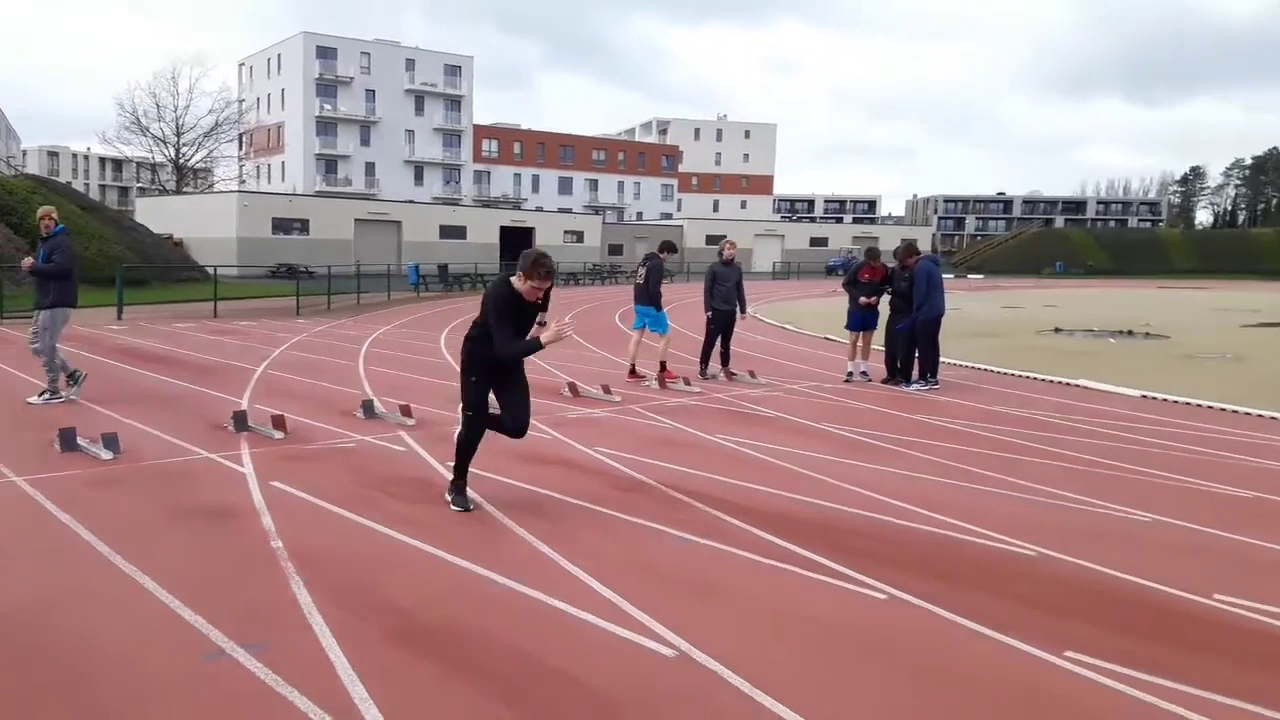

In [67]:
cv2_imshow(results1[175].orig_img)